# Welfare Costs of Short-Run Price Volatility

In [17]:
import os
import numpy as np
from scipy import stats
import pandas as pd
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
%matplotlib inline
plt.style.use('seaborn-whitegrid')
mpl.style.use('seaborn')
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

## **1: Setup**

We consider the incredibly simple static maximization problem:

$$\begin{align}
    U &= \max_{C,E} C^{\alpha}E^{1-\alpha}, \\ 
    \text{s.t. }I&= C+pE, 
\end{align}$$
with the standard simple solution
$$\begin{align}
    C &= \alpha I \\ 
    E &= (1-\alpha)\dfrac{I}{p}
\end{align}$$

Consider instead the case where $E$ is split into a number of hours $h\in\lbrace 1,...,H\rbrace$ with hourly prices $p_h$. Augment the utility function to accomodate bliss point preferences / price volatility aversion. As outlined in the paper this implies the form
$$\begin{align}
    U = \max_{C,E} C^{\alpha}E^{1-\alpha}+u^{hour}(E_1,...,E_H)+u^{h,scale}(E),
\end{align}$$
with $E=\sum_h E_h$ and $p = \sum_h p_hE_h/E$.

The first order conditions are now on the form:
$$\begin{align}
\lambda &= \alpha \left(\dfrac{C}{E}\right)^{\alpha-1} \tag{1}\\
p_h \lambda &= (1-\alpha)\left(\dfrac{C}{E}\right)^{\alpha}+\dfrac{\partial u^{hour}}{\partial E_h}+\dfrac{\partial u^{h,scale}}{\partial E} \tag{2}
\end{align}$$

Combination of (2) for hours $h,j$ implies
$$\begin{align}
    \dfrac{\partial u^{hour}}{\partial E_h} - \dfrac{\partial u^{hour}}{\partial E_j} = \lambda(p_h-p_j). \tag{3}
\end{align}$$

## **2: Logit example**

The logit-like example applies the functional forms (notation from paper adopted):

$$\begin{align}
    u_h &=  \dfrac{1}{\sigma}\ln\left(\tilde{u}_h\right) \\
    \tilde{u}_h&= \exp\left(\sigma\lambda(p_h-p_t)\right) \\
    \chi_h(\tilde{u}_h) &= \underline{D}+\dfrac{(1-\underline{D})(\overline{D}-\underline{D})}{1-\underline{D}+(\overline{D}-1)\tilde{u}_h}
\end{align}$$

Using the interpretation of the bliss point as $E_t^*$ (the level in absence of price volatility), the implied utility function becomes (notation in the paper):

$$\begin{align}
    u_h^{hour} = \dfrac{1}{\sigma}\left[E_h\ln\left(\dfrac{1-\underline{D}}{\overline{D}-1}\right)-(E_h-\underline{E}_h)\ln\left(E_h-\underline{E}_h\right)-\left(\overline{E}_h-E_h\right)\ln\left(\overline{E}_h-E_h\right)\right]
\end{align}$$

### **2.1: Parameter values**

Set parameter values

In [3]:
par = {'I': 100,
       'alpha': 0.5,
       'eps': 0.00001} # Added small value for numerical stability

Add random sample of prices (here random normal draws) and habit shares $g_h\in(0,1)$ (normalized truncated normal draws):

In [25]:
np.var(par['gh'])

7.3238795540792615e-09

In [13]:
par['gh']

array([1.84513965e-04, 2.94051929e-05, 1.65670066e-04, ...,
       1.91401811e-04, 1.24090995e-04, 1.15029137e-04])

In [4]:
par['ph'] = np.random.normal(100,20,8760)
rs_g = stats.truncnorm.rvs(0,100,size=8760)
par['gh'] = rs_g/sum(rs_g)

Logit parameters:

In [4]:
par['Upper']= 2
par['Lower']= 0
par['sigma']= 10

Add functional forms:

In [5]:
par['chi_h'] = lambda x: par['Lower']+((1-par['Lower'])*(par['Upper']-par['Lower']))/(1-par['Lower']+(par['Upper']-1)*x)
par['utilde_h'] = lambda lambda_,ph,pt: np.exp(par['sigma']*lambda_*(ph-pt))

*NB: We can easily verify that the $\chi_h$ function exhibits a fixed-point around 1*

In [6]:
par['chi_h'](1)

1.0

### **2.2: Solution without flexible demand**

We compute $p^*,E^*,C^*,\lambda^*$ under assumption of no price volatility:

In [7]:
sol = {}
sol['pstar'] = sum(par['gh']*par['ph'])
sol['Estar'] = (1-par['alpha'])*par['I']/sol['pstar']
sol['Cstar'] = par['alpha']*par['I']
sol['lambda_star'] = par['alpha']*(sol['Cstar']/sol['Estar'])**(par['alpha']-1)
sol['Ehstar'] = par['gh']*sol['Estar']
sol['Ehlower'] = par['gh']*par['Lower']*sol['Estar']-par['eps']
sol['Ehupper'] = par['gh']*par['Upper']*sol['Estar']+par['eps']

Scale of disutility from $u^{hour}$ term in absence of price variation:

In [8]:
sol['uhour_star'] = (1/par['sigma'])*sum(sol['Ehstar']*np.log((1-par['Lower'])/(par['Upper']-1))-(sol['Ehstar']-sol['Ehlower'])*np.log(sol['Ehstar']-sol['Ehlower'])-(sol['Ehupper']-sol['Ehstar'])*np.log(sol['Ehupper']-sol['Ehstar']))

### **2.3: Solution with flexible demand**

Logit shares (as a function of lambda):

In [9]:
sol['sh_f'] = lambda lambda_: par['gh'] * par['chi_h'](par['utilde_h'](lambda_,par['ph'],sol['pstar']))
sol['Eh_f'] = lambda lambda_: sol['sh_f'](lambda_)*sol['Estar']

Compare endogeonus and exogenous shares (with $\lambda$ fixed at value without price volatility)

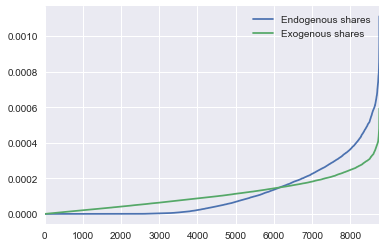

In [10]:
pd.DataFrame({'Endogenous shares': pd.Series(sol['sh_f'](sol['lambda_star'])).sort_values().reset_index(drop=True),
              'Exogenous shares': pd.Series(par['gh']).sort_values().reset_index(drop=True)}).plot();

Utility as a function of $\lambda$:

In [11]:
sol['uhour_function'] = lambda lambda_: (1/par['sigma'])*sum(sol['Eh_f'](lambda_)*np.log((1-par['Lower'])/(par['Upper']-1))-(sol['Eh_f'](lambda_)-sol['Ehlower'])*np.log(sol['Eh_f'](lambda_)-sol['Ehlower'])-(sol['Ehupper']-sol['Eh_f'](lambda_))*np.log(sol['Ehupper']-sol['Eh_f'](lambda_)))

Value in the case of $\lambda^*$ (as a benchmark):

In [12]:
data = pd.DataFrame({'Upper bound': sol['Ehupper'],
              'Actual E': sol['Eh_f'](sol['lambda_star'])})
data['diff'] = data['Upper bound']-data['Actual E']

Utility as a function of $\lambda$, including the normalization around zero:

In [13]:
sol['uhour_sum'] = lambda lambda_: sol['uhour_function'](lambda_)-sol['uhour_star']

### **2.4: Illustrating the cost function**

**1: Plot the utility as a function of $\lambda$**

In [14]:
lambdagrid = np.linspace(0,1,100)

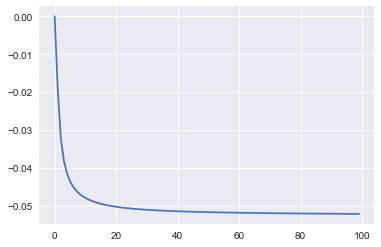

In [15]:
sol['uhour_lambdagrid'] = np.array([sol['uhour_sum'](i) for i in lambdagrid])
plt.plot(sol['uhour_lambdagrid']);

With $\lambda$ being the shadow-value of income, however, we can check that the *total* effect on welfare is always positive (otherwise the household simply wouldn't react)

In [16]:
# What's the income the household saves from adjusting to price fluctuations:
sol['shares_lambdagrid'] = np.array([sum(sol['sh_f'](i)*par['ph'])-sol['pstar']*sol['Estar'] for i in lambdagrid])
# What's the effect on utility:
sol['uincome_lambdagrid'] = sol['shares_lambdagrid']*lambdagrid

**2: Compare welfare with and without flexible demand**

Without flexible prices:

In [20]:
sol['Cstar']**(par['alpha'])*sol['Estar']**(1-par['alpha'])

5.004835319766224

Assume $\lambda=\lambda^*$. The utility in this case:

In [36]:
E_year_lambdastar = sum(sol['Eh_f'](sol['lambda_star']))
C_year_lambdastar = par['I']-sum(sol['Eh_f'](sol['lambda_star'])*par['ph'])

In [39]:
C_year_lambdastar**(par['alpha'])*E_year_lambdastar**(1-par['alpha'])+sol['uhour_sum'](sol['lambda_star'])

5.341557116754611